# Mini Project 3

In [8]:
EMBEDDING_DIMENSION = 50
CONTEXT_WINDOW = 4
NEGATIVE_SAMPLES = 2
UNKNOWN_TOKEN = "<មម>"

In [66]:
from khmernltk import word_tokenize
from collections import Counter
import numpy as np
import tensorflow as tf

## Scratch: Read, Clean and Tokenizing the Corpus

In [47]:
# Load and preprocess text
with open("temples.txt", "r", encoding="utf-8") as file:
    text = file.read()

In [48]:
unclean_tokens = word_tokenize(text)
print(f"number of tokens: {len(unclean_tokens)}")
token_counters = Counter(unclean_tokens)
print(f"Original vocab size: {len(token_counters)}")

number of tokens: 11521
Original vocab size: 2276


### Clean the tokens

In [76]:
import re

cleaned_vocabs = Counter()

zero_width_space = '\u200B' # zero width space from Internet
zero_width_space2 = '\u200C' # zero space from experiment below
ignores = [" ","-", "—", ":", "(", ")", "។", "[", "]", "ៗ", "៕", "៛", "៚", "៙", "៘", "៖", "\"",""]
ignores.append(zero_width_space)
ignores.append(zero_width_space2)

for token, count in token_counters.items():
    if token.strip() and token not in ignores and not re.match(r"^\[.*$", token) and not re.match(r".*\]$", token) and not re.match(r"^\(.*$", token) and not re.match(r".*\)$", token) and not re.match(r"^\d+$", token) and not token.isascii():
        cleaned_vocabs[token] = count

print(f"Clean vocabs: {len(cleaned_vocabs)}")

Clean vocabs: 2091


In [74]:
def get_unicode_code_points(token):
    """
    Get the Unicode code points of each character in the token.
    """
    return [ord(char) for char in token]

def format_code_points_as_hex(code_points):
    """
    Format the Unicode code points as hexadecimal strings.
    """
    return [f"U+{code_point:04X}" for code_point in code_points]

In [77]:
with open("cleaned_vocabs.txt", "w", encoding="utf-8") as file:
    row = []
    for token, count in cleaned_vocabs.items():
        # code_points = get_unicode_code_points(token)
        # hex_code_points = format_code_points_as_hex(code_points)
        row.append(f"{token} {count}")

    file.write("\n".join(row))

In [79]:
cleaned_tokens = []
for token in unclean_tokens:
    if token in cleaned_vocabs:
        cleaned_tokens.append(token)

print(f"number of cleaned tokens: {len(cleaned_tokens)}")
print(f"Cleaned tokens: {cleaned_tokens[:10]}")

number of cleaned tokens: 9086
Cleaned tokens: ['ប្រាសាទ', 'អង្គរវត្ត', 'ឬ', 'ប្រាសាទ', 'អង្គរ', 'តូច', 'មាន', 'ទីតាំង', 'ស្ថិត', 'នៅ']


In [80]:
with open("cleaned_tokens.txt", "w", encoding="utf-8") as file:
    file.write(" ".join(cleaned_tokens))

## Alternative: Read Cleaned tokens

In [1]:
# Read cleaned tokens
with open("cleaned_tokens.txt", "r", encoding="utf-8") as file:
    cleaned_tokens = file.read().split()

In [9]:
print(f"number of cleaned tokens: {len(cleaned_tokens)}")
print(f"Cleaned tokens: {cleaned_tokens[:10]}")

number of cleaned tokens: 9086
Cleaned tokens: ['ប្រាសាទ', 'អង្គរវត្ត', 'ឬ', 'ប្រាសាទ', 'អង្គរ', 'តូច', 'មាន', 'ទីតាំង', 'ស្ថិត', 'នៅ']


# I. Word Embedding

## Skip-gram model
Given a Khmer text corpus “temples.txt” extracted from 3 Wikipedia pages1, build a skip-gram
model/classifier to find representation/embedding of each Khmer word in the corpus. Use the
following settings for your implementation:
- The word embedding has a dimension of 50
- For the skip-gram model, use context window $L$ = ±4 and negative sampling with $k$ = 2
- To tokenize word, you can use Khmer nltk2
- Your vocabulary should contain meaningful and frequent words so:
    - Words whose frequency is less than 10 are ignored
    - Spaces are considered a stop word and are also ignored

### Preparing dataset

#### Clean vocabs and less frequency words  (<2)

In [5]:
vocabs_counter = Counter(cleaned_tokens)

In [17]:
FREQURNCY_THRESHOLD = 2
limited_vocabs = set()
removed_vocabs = set()
for token, count in vocabs_counter.items():
    if count >= FREQURNCY_THRESHOLD:
        limited_vocabs.add(token)
    else:
        removed_vocabs.add(token)
        limited_vocabs.add(UNKNOWN_TOKEN)

limited_vocabs = list(limited_vocabs)
len(limited_vocabs), limited_vocabs

(940,
 ['ផ្ទាំង',
  'តោ',
  'ត្រូវ',
  'អភិវឌ្ឍ',
  'ដូច',
  'អ្នកស្រាវជ្រាវ',
  'និង',
  'ខាងក្នុង',
  'សំនង់',
  'ចតុមុខ',
  'ឡើងវិញ',
  'ប៉ុណ្ណោះ',
  'បី',
  'ដោយសារតែ',
  'ជញ្ជាំង',
  'ជីវិត',
  'រា',
  'គ.ស.',
  'ជាមួយនឹង',
  'ចែក',
  'គេ',
  'មកពី',
  'កេរ',
  'បុរី',
  'ព្រះវិហារ',
  'រហូតមក',
  'យក',
  'ទាំងអស់',
  'ក្រោយមក',
  'នៅតែ',
  'នាម',
  'បុរៈ',
  'ច្រក',
  'ចំណែក',
  'ខ្លះ',
  'ដំណាក់កាល',
  'ផ្ទុយ',
  'ចម្លាក់',
  'ចំ',
  'រចនាសម្ព័ន្ធ',
  'ដាក់បញ្ចូល',
  'ថ្វាយ',
  'ចតុកោណ',
  'មូល',
  'នឹង',
  'ពីមុន',
  'ទាំងស្រុង',
  'ទេវរាជ',
  'វាទ',
  'មែន',
  'ល្បី',
  'ចេញ',
  'ដំណាប់',
  'ដោយសារ',
  'សករាជ',
  'សព',
  'ថ្ម',
  'ទេវៈ',
  'រដូវ',
  'ឯកសារ',
  'ជិត',
  'ប្រម៉ាណ',
  'បុរាណ',
  'វាល',
  'រស់រវើក',
  '៩៥ម៉ែត្រ',
  'គ្មាន',
  'ឧទ្ទិស',
  'ដុំ',
  'អ្វី',
  'ក្បឿង',
  'ភាគ',
  'សមុទ្រ',
  'គ្រា',
  'អង់ហ៊្រី',
  'ខាងលិច',
  'ហ្សក',
  'រាត្រី',
  'បន្ទាប់មក',
  'សាច់រឿង',
  'ពិសេស',
  'ចូលរួម',
  'ការតុបតែង',
  'ត្បិត',
  'ទុក',
  'ក្រោម',
  'ម្តង',
  'ហិណ្ឌូ',
  'ផ

In [18]:
removed_vocabs

{'ជួល',
 'ឧត្តរមានជ័យ',
 'ឯកភាព',
 'កន្ទុយ',
 'គត់',
 'ការប៉ុនប៉ង',
 'សេវការ',
 'វិជ្ជមាន',
 'អនុវត្តន៍',
 'ការយក',
 'ចន្លោះស',
 'ទូទៅ',
 'ការទូត',
 'ធម្មនន្ទ',
 '៤៣ម',
 'សឹង',
 'ពិតជា',
 'ការចំណាយ',
 'បែក',
 'បទដ្ឋាន',
 'សក្ដានុពល',
 'ចោឡ៊',
 'បន្ទាប់បន្សំ',
 'រ៊',
 'ព្រះព្រហ្ម',
 'វីរក',
 'ភុវតមហេស្វរៈ',
 'ស្រឡៅ',
 'ស្រទាប',
 'ភូវន',
 'ឌួ',
 'ទូលាយ',
 'ព្រះសង្ឃ',
 'តំណត',
 'អាហារ',
 'ឯក',
 'ស្រោប',
 'ព្រះគូ្រ',
 'រាវនៈ',
 '២៩៩គីឡូម៉ែត្រ',
 'រុក្ខជាតិ',
 'ការទ្រុឌទ្រោម',
 'ឥន្ទ',
 'ជោគជ័យ',
 'ផារ៉ា',
 'សំអាត',
 'ខំ',
 'មហ៊ត',
 'ផលិតកម្ម',
 'អាយុកាល2លាន',
 'ជំរុញ',
 'វិច្ឆិកា',
 'ចងចាំ',
 'ហ្រង់រី',
 'ហាក់',
 'ការបូក',
 'មូលដ្ឋាន',
 'អ្នកប្រាជ្ញ',
 'កេសាបថ',
 'និយ័តកម្ម',
 'សម្ដែង',
 'យម',
 'បង្រួម',
 'សង្ឃ',
 'ពស់',
 'សហរដ្ឋ',
 'ត្រកូល',
 'គ្រហស្ថ',
 'បិទ',
 'ពិនិត្យ',
 'ជាយ',
 'ព្រះសព',
 'អាក្រក់',
 'កង្វល់',
 'រទេះ',
 'ហ្សឹកត់សម្គាល់',
 'ឆ្មារ',
 'ត្រួតត្រា',
 'ព្រំប្រទល់',
 'ល័យ',
 '៣ភ្លាម',
 'ផ្ទុះ',
 'ទ្រ',
 'សម្បត្តិ',
 'បាខែង',
 'ពិតប្រាកដ',
 'លំនៅឋាន',
 'អេសុី',
 'ប្រណីត',
 'ទ

#### Word2Number

In [19]:
# Word to index and index to word
word_to_index = {word: i for i, word in enumerate(limited_vocabs)}
index_to_word = {i: word for word, i in word_to_index.items()}

In [40]:
print(word_to_index[UNKNOWN_TOKEN])

403


In [43]:
np.save("vocab_to_index.npy", word_to_index)

In [41]:
limited_tokens = []
data = []
for token in cleaned_tokens:
    if token in limited_vocabs:
        limited_tokens.append(token)
        data.append(word_to_index[token])
    else:
        limited_tokens.append(UNKNOWN_TOKEN)
        data.append(403)

In [42]:
print(len(word_to_index), word_to_index)
print(index_to_word)
print(len(limited_tokens), limited_tokens)
print(len(data), data)

940 {'ផ្ទាំង': 0, 'តោ': 1, 'ត្រូវ': 2, 'អភិវឌ្ឍ': 3, 'ដូច': 4, 'អ្នកស្រាវជ្រាវ': 5, 'និង': 6, 'ខាងក្នុង': 7, 'សំនង់': 8, 'ចតុមុខ': 9, 'ឡើងវិញ': 10, 'ប៉ុណ្ណោះ': 11, 'បី': 12, 'ដោយសារតែ': 13, 'ជញ្ជាំង': 14, 'ជីវិត': 15, 'រា': 16, 'គ.ស.': 17, 'ជាមួយនឹង': 18, 'ចែក': 19, 'គេ': 20, 'មកពី': 21, 'កេរ': 22, 'បុរី': 23, 'ព្រះវិហារ': 24, 'រហូតមក': 25, 'យក': 26, 'ទាំងអស់': 27, 'ក្រោយមក': 28, 'នៅតែ': 29, 'នាម': 30, 'បុរៈ': 31, 'ច្រក': 32, 'ចំណែក': 33, 'ខ្លះ': 34, 'ដំណាក់កាល': 35, 'ផ្ទុយ': 36, 'ចម្លាក់': 37, 'ចំ': 38, 'រចនាសម្ព័ន្ធ': 39, 'ដាក់បញ្ចូល': 40, 'ថ្វាយ': 41, 'ចតុកោណ': 42, 'មូល': 43, 'នឹង': 44, 'ពីមុន': 45, 'ទាំងស្រុង': 46, 'ទេវរាជ': 47, 'វាទ': 48, 'មែន': 49, 'ល្បី': 50, 'ចេញ': 51, 'ដំណាប់': 52, 'ដោយសារ': 53, 'សករាជ': 54, 'សព': 55, 'ថ្ម': 56, 'ទេវៈ': 57, 'រដូវ': 58, 'ឯកសារ': 59, 'ជិត': 60, 'ប្រម៉ាណ': 61, 'បុរាណ': 62, 'វាល': 63, 'រស់រវើក': 64, '៩៥ម៉ែត្រ': 65, 'គ្មាន': 66, 'ឧទ្ទិស': 67, 'ដុំ': 68, 'អ្វី': 69, 'ក្បឿង': 70, 'ភាគ': 71, 'សមុទ្រ': 72, 'គ្រា': 73, 'អង់ហ៊្រី': 74, 'ខាងលិច': 75, 'ហ្ស

In [44]:
np.save("data.npy", np.array(data))

#### Create dataset

In [45]:
def generate_skipgram_data(token_indices, window_size):
    """Generate skip-gram pairs."""
    skipgram_pairs = []
    for center_idx, center_word in enumerate(token_indices):
        context_range = range(max(center_idx - window_size, 0), 
                                min(center_idx + window_size + 1, len(token_indices)))
        for context_idx in context_range:
            if center_idx != context_idx:
                skipgram_pairs.append((center_word, token_indices[context_idx]))
    return skipgram_pairs

In [46]:
training_data = generate_skipgram_data(data, CONTEXT_WINDOW)

In [47]:
print(f"Number of training data: {len(training_data)}")
print(f"Training data: {training_data[:10]}")

Number of training data: 72668
Training data: [(672, 532), (672, 308), (672, 672), (672, 519), (532, 672), (532, 308), (532, 672), (532, 519), (532, 109), (308, 672)]


### Skip-Gram Model 2 - Simple using tensorflow

In [31]:
def generate_batch(training_data, vocab_size, batch_size=128, negative_samples=2):
    total_positive_samples = 0
    total_negative_samples = 0
    while True:
        x, y = [], []
        for _ in range(batch_size):
            target_word, context_word = training_data[
                np.random.randint(0, len(training_data))
            ]
            x.append(target_word)
            y.append(context_word)
            total_positive_samples += 1
            for _ in range(negative_samples):
                negative_word = np.random.randint(0, vocab_size)
                x.append(target_word)
                y.append(negative_word)
                total_negative_samples += 1
        # print(f"Total positive samples: {total_positive_samples}")
        # print(f"Total negative samples: {total_negative_samples}")
        yield np.array(x), np.array(y)

In [33]:
batch_size = 128
next(generate_batch(training_data, len(limited_vocabs), batch_size, NEGATIVE_SAMPLES))

(array([359, 359, 359, 403, 403, 403, 611, 611, 611,   6,   6,   6, 403,
        403, 403, 775, 775, 775, 735, 735, 735, 403, 403, 403, 311, 311,
        311, 802, 802, 802, 694, 694, 694,  67,  67,  67, 884, 884, 884,
         62,  62,  62, 672, 672, 672, 629, 629, 629, 464, 464, 464, 114,
        114, 114, 811, 811, 811, 699, 699, 699, 843, 843, 843, 403, 403,
        403,  26,  26,  26,  76,  76,  76, 423, 423, 423, 408, 408, 408,
        311, 311, 311, 736, 736, 736, 133, 133, 133, 675, 675, 675, 403,
        403, 403, 494, 494, 494, 453, 453, 453, 107, 107, 107, 907, 907,
        907, 357, 357, 357, 125, 125, 125, 352, 352, 352, 403, 403, 403,
        546, 546, 546, 928, 928, 928, 736, 736, 736, 589, 589, 589, 403,
        403, 403, 403, 403, 403, 238, 238, 238, 687, 687, 687, 875, 875,
        875, 307, 307, 307, 406, 406, 406, 356, 356, 356, 782, 782, 782,
        914, 914, 914, 694, 694, 694,   6,   6,   6, 403, 403, 403, 312,
        312, 312, 392, 392, 392, 652, 652, 652, 580

In [34]:
steps_per_epoch = len(training_data) // batch_size
steps_per_epoch

567

In [38]:
sg_model2 = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(len(limited_vocabs), EMBEDDING_DIMENSION, input_length=1),
        tf.keras.layers.Dense(len(limited_vocabs), activation="softmax"),
    ]
)
sg_model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [39]:
sg_model2.fit(
    generate_batch(training_data, len(limited_vocabs), batch_size, NEGATIVE_SAMPLES),
    steps_per_epoch=steps_per_epoch,
    epochs=50
)

Epoch 1/50
567/567 [==============================] - 4s 7ms/step - loss: 6.7279 - accuracy: 0.0391
Epoch 2/50
567/567 [==============================] - 4s 6ms/step - loss: 6.6178 - accuracy: 0.0433
Epoch 3/50
567/567 [==============================] - 4s 7ms/step - loss: 6.6081 - accuracy: 0.0428
Epoch 4/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5986 - accuracy: 0.0424
Epoch 5/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5901 - accuracy: 0.0424
Epoch 6/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5808 - accuracy: 0.0419
Epoch 7/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5711 - accuracy: 0.0414
Epoch 8/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5664 - accuracy: 0.0407
Epoch 9/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5563 - accuracy: 0.0405
Epoch 10/50
567/567 [==============================] - 4s 7ms/step - loss: 6.5492 - accuracy: 0.0394

KeyboardInterrupt: 

In [30]:
# Extract the word embeddings
embeddings2 = sg_model2.layers[0].get_weights()[0]
embeddings2

array([[-0.11182633,  0.06225012,  0.03999365, ...,  0.09716614,
        -0.22655903, -0.31317216],
       [-0.15385886, -0.16094327, -0.18639304, ...,  0.41144848,
        -0.27976117,  0.04344371],
       [-0.03213493, -0.11641014, -0.01208379, ..., -0.4148307 ,
         0.10783792,  0.03114374],
       ...,
       [ 0.08485515,  0.20776129,  0.27263108, ..., -0.09409647,
        -0.20459221,  0.13095443],
       [ 0.01761165, -0.06932025, -0.10412469, ...,  0.1424022 ,
         0.07342461,  0.01953124],
       [ 0.01401601,  0.00989925, -0.02110025, ..., -0.04379189,
        -0.01745558, -0.02654355]], dtype=float32)

In [31]:
# Save the embeddings
np.save("I_embeddings2.npy", embeddings2)

### Skip Game Model 3 - Custom class using tensorflow

In [48]:
import random

def get_negative_samples(vocab_size, positive_samples, num_negative):
    """Generate negative samples."""
    negatives = []
    for _ in range(len(positive_samples)):
        negative_samples = random.choices(range(vocab_size), k=num_negative)
        negatives.append(negative_samples)
    return negatives

In [49]:
class SkipGramModel3(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel3, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=1, name="target_embedding")
        self.context_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=1, name="context_embedding")

    def call(self, inputs):
        target, context, negative_samples = inputs
        target_embed = self.target_embedding(target)
        context_embed = self.context_embedding(context)
        negative_embed = self.context_embedding(negative_samples)

        pos_similarity = tf.reduce_sum(target_embed * context_embed, axis=-1)
        neg_similarity = tf.reduce_sum(target_embed[:, None, :] * negative_embed, axis=-1)

        pos_loss = -tf.math.log(tf.keras.activations.sigmoid(pos_similarity))
        neg_loss = -tf.reduce_sum(tf.math.log(tf.keras.activations.sigmoid(-neg_similarity)), axis=-1)

        return tf.reduce_mean(pos_loss + neg_loss)


In [50]:
def train_skipgram_model3(skipgram_pairs, vocab_size, embedding_dim=50, neg_samples=2, epochs=20, batch_size=256, learning_rate=0.01):
    # Build the Skip-gram model
    model = SkipGramModel3(vocab_size, embedding_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    targets, contexts = zip(*skipgram_pairs)

    # Generate negative samples
    negative_samples = get_negative_samples(vocab_size, skipgram_pairs, neg_samples)

    # Convert lists to NumPy arrays
    targets = np.array(targets, dtype=np.int32)
    contexts = np.array(contexts, dtype=np.int32)
    negative_samples = np.array(negative_samples, dtype=np.int32)

    # Ensure `negative_samples` has the shape (num_pairs, k) for proper batching
    negative_samples = np.reshape(negative_samples, (len(targets), -1))

    # Prepare the dataset
    dataset = tf.data.Dataset.from_tensor_slices((targets, contexts, negative_samples))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataset:
            target_batch, context_batch, negative_batch = batch

            with tf.GradientTape() as tape:
                loss = model([target_batch, context_batch, negative_batch])

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            total_loss += loss.numpy()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    return model

In [52]:
sg_model3 = train_skipgram_model3(training_data, len(limited_vocabs), learning_rate=0.01, epochs=30)

Epoch 1/30, Loss: 417.5873
Epoch 2/30, Loss: 360.1831
Epoch 3/30, Loss: 313.8402
Epoch 4/30, Loss: 276.5340
Epoch 5/30, Loss: 250.9222
Epoch 6/30, Loss: 234.4859
Epoch 7/30, Loss: 223.6599
Epoch 8/30, Loss: 216.5922
Epoch 9/30, Loss: 211.8193
Epoch 10/30, Loss: 208.5036
Epoch 11/30, Loss: 205.7782
Epoch 12/30, Loss: 203.8619
Epoch 13/30, Loss: 202.6491
Epoch 14/30, Loss: 201.0268
Epoch 15/30, Loss: 200.3317
Epoch 16/30, Loss: 199.4065
Epoch 17/30, Loss: 199.1083
Epoch 18/30, Loss: 198.3832
Epoch 19/30, Loss: 197.5991
Epoch 20/30, Loss: 197.4611
Epoch 21/30, Loss: 197.2432
Epoch 22/30, Loss: 197.1349
Epoch 23/30, Loss: 196.3873
Epoch 24/30, Loss: 196.0038
Epoch 25/30, Loss: 195.8183
Epoch 26/30, Loss: 196.0221
Epoch 27/30, Loss: 195.7991
Epoch 28/30, Loss: 195.3326
Epoch 29/30, Loss: 195.2885
Epoch 30/30, Loss: 195.5691


In [53]:
embedding_layer = sg_model3.get_layer("target_embedding")
embeddings3 = embedding_layer.get_weights()[0]
embeddings3

array([[-0.19637547, -1.0996348 , -0.73277396, ...,  0.12947609,
         0.5895702 ,  0.24599902],
       [-1.1973345 , -1.3222591 ,  1.4371519 , ..., -1.5491412 ,
         0.02791055,  0.46920952],
       [ 0.14370944, -0.9285129 , -0.5585619 , ...,  0.71297336,
         0.54921967, -1.2220818 ],
       ...,
       [ 1.0826856 ,  0.34496424,  1.3186041 , ..., -0.8873057 ,
        -2.6411304 , -0.4031768 ],
       [-0.8924977 , -1.7446518 , -0.5322465 , ...,  0.4633024 ,
         0.7599996 , -0.66163814],
       [-0.3117759 ,  0.54349035, -2.5317588 , ...,  1.3983467 ,
        -0.93742   , -0.5387908 ]], dtype=float32)

In [54]:
print(embeddings3.shape)

(940, 50)


In [55]:
# Loop through the embeddings and map to words
word_to_embedding = {}
for i, word in index_to_word.items():
    word_to_embedding[word] = embeddings3[i]

In [56]:
word_to_embedding

{'ផ្ទាំង': array([-0.19637547, -1.0996348 , -0.73277396,  0.3032817 ,  1.267991  ,
         0.129088  , -0.07310733, -1.6329136 , -2.4801815 ,  0.41576672,
        -0.0500966 ,  0.8121467 , -0.2810696 , -1.1549846 , -1.1522864 ,
         0.04394186, -1.0822406 ,  0.16610254,  0.41805446,  0.6005976 ,
        -0.11573997, -0.66899174,  1.4114743 , -0.94926625, -1.9811927 ,
         2.2213287 ,  0.24965446, -0.83495533,  0.7452071 ,  0.11327396,
         1.0741395 , -0.8491967 , -0.28196174,  0.170886  , -1.0118997 ,
        -0.34063128,  0.82149917,  0.16912372, -0.6325639 , -1.3653077 ,
         0.7252758 ,  1.4895812 , -1.0573139 , -0.2979253 ,  0.5713348 ,
         0.75878435, -1.1875654 ,  0.12947609,  0.5895702 ,  0.24599902],
       dtype=float32),
 'តោ': array([-1.1973345 , -1.3222591 ,  1.4371519 ,  1.3951288 ,  1.0091388 ,
        -1.3834184 ,  0.17886   , -1.385212  , -2.11518   , -0.07304926,
        -0.18319207, -0.15861039, -0.5980901 ,  0.46404403,  1.1978018 ,
         1.

In [57]:
np.save("word_to_embedding3.npy", word_to_embedding)

### Skip Game Model 4

In [77]:
import numpy as np

def skipgram(tokenized, vocab_size, window_size=4, negative_samples=2):
    """
    Generate skip-gram pairs with positive and negative examples manually.

    Args:
    - tokenized: List of word indices (tokenized corpus).
    - vocab_size: Size of the vocabulary.
    - window_size: Size of the context window (± window_size).
    - negative_samples: Number of negative samples to generate per positive pair.

    Returns:
    - targets: Target words (center words).
    - contexts: Context words (positive and negative examples).
    - labels: Labels for training (1 for positive pairs, 0 for negative pairs).
    """
    targets, contexts, labels = [], [], []

    for i, target in enumerate(tokenized):
        # Define context window boundaries
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, len(tokenized))

        # Positive examples: Words within the context window
        positive_context = [tokenized[j] for j in range(start, end) if j != i]
        for context in positive_context:
            targets.append(target)
            contexts.append(context)
            labels.append(1)  # Positive pair

        # Negative sampling: Randomly sample words outside the context
        negative_context = np.random.choice(
            vocab_size, 
            size=negative_samples, 
            replace=False
        )
        for neg_context in negative_context:
            targets.append(target)
            contexts.append(neg_context)
            labels.append(0)  # Negative pair

    return np.array(targets), np.array(contexts), np.array(labels)

In [78]:
# Generate Skip-gram Data
targets, contexts, labels = skipgram(data, len(limited_vocabs), window_size=CONTEXT_WINDOW, negative_samples=NEGATIVE_SAMPLES)
targets[:2], contexts[:2], labels[:2]

(array([672, 672]), array([532, 308]), array([1, 1]))

In [79]:
def build_skipgram_model(vocab_size, embedding_dim):
    """Build a skip-gram model using negative sampling."""
    # Inputs for target and context words
    target_input = tf.keras.Input(shape=(1,), name="target_input")
    context_input = tf.keras.Input(shape=(1,), name="context_input")
    
    # Embedding layers for target and context
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        input_length=1, 
        name="embedding"
    )
    
    target_embedding = embedding_layer(target_input)
    context_embedding = embedding_layer(context_input)
    
    # Compute dot product
    dot_product = tf.reduce_sum(target_embedding * context_embedding, axis=-1)
    output = tf.keras.layers.Activation("sigmoid")(dot_product)
    
    # Build and compile model
    model = tf.keras.Model(inputs=[target_input, context_input], outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy")
    return model

In [80]:
model = build_skipgram_model(len(limited_vocabs), EMBEDDING_DIMENSION)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 context_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                47000     ['target_input[0][0]',        
                                                                     'context_input[0][0]']       
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 1, 50)                0         ['embedding[0][0]',       

In [81]:
epochs = 10
batch_size = 32
# Train the Model
history = model.fit(
    [targets, contexts],
    labels,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.4762
Epoch 2/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.4293
Epoch 3/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.4136
Epoch 4/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.3874
Epoch 5/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.3566
Epoch 6/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.3265
Epoch 7/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.2994
Epoch 8/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.2760
Epoch 9/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.2561
Epoch 10/10
2839/2839 [==============================] - 5s 2ms/step - loss: 0.2391


In [84]:
# Extract Embeddings
embeddings = model.get_layer("embedding").get_weights()[0]
embeddings

array([[-0.39714095,  0.28081563, -0.08421252, ..., -0.38197738,
         0.15043499, -0.1884143 ],
       [ 0.40780312,  0.0203452 ,  0.04022121, ..., -0.43483904,
         0.5911779 , -0.22888137],
       [-0.10494262, -0.0596906 , -0.40379745, ...,  0.22276442,
        -0.17462629, -0.3857255 ],
       ...,
       [ 0.01783764,  0.35291246,  0.06971829, ..., -0.10051635,
        -0.39859483, -0.28690222],
       [-0.01028689, -0.16240998, -0.27351487, ..., -1.0285581 ,
         0.594806  ,  0.31954393],
       [-0.06068081, -0.29742426, -0.11377298, ..., -0.21418564,
        -0.22083393,  0.775368  ]], dtype=float32)

In [85]:
# Loop through the embeddings and map to words
word_to_embedding4 = {}
for i, word in index_to_word.items():
    word_to_embedding4[word] = embeddings[i]

In [86]:
word_to_embedding4

{'ផ្ទាំង': array([-0.39714095,  0.28081563, -0.08421252, -0.1807773 , -0.21726531,
        -0.22500634, -0.47116008, -0.2390432 , -0.00979427, -0.02148806,
        -0.39863905, -0.04124927, -0.10599356,  0.29695427, -0.24831249,
         0.5961969 ,  0.866331  , -0.22148474,  0.23587838,  0.0959111 ,
         0.05643222,  0.38016716,  0.20066826,  1.1319199 , -0.03136902,
        -0.00996196, -0.01817536, -0.00691926,  0.19779   ,  0.15323098,
         0.41645375,  0.04460753,  0.09268972,  0.20427322, -0.18640697,
        -0.57776815,  0.35160163,  0.6146208 , -0.04729665,  0.42608586,
         0.97485965,  0.11790054, -0.15671258, -0.1975034 , -0.17668343,
        -0.27233124,  0.03479195, -0.38197738,  0.15043499, -0.1884143 ],
       dtype=float32),
 'តោ': array([ 0.40780312,  0.0203452 ,  0.04022121,  0.03311273, -0.44348422,
        -0.24437413, -0.01779308, -0.22360754,  0.5568268 ,  0.05519613,
        -0.27859145, -0.2911076 ,  0.3360994 ,  0.18846451,  0.29135182,
         0.

In [87]:
np.save("word_to_embedding4.npy", word_to_embedding4)

## Read trained embeddings

In [88]:
file_word_to_embeddings = "word_to_embedding4.npy" # Change as you prefer

In [89]:
word_to_embeddings = np.load(file_word_to_embeddings, allow_pickle=True).item()
word_to_embeddings

{'ផ្ទាំង': array([-0.39714095,  0.28081563, -0.08421252, -0.1807773 , -0.21726531,
        -0.22500634, -0.47116008, -0.2390432 , -0.00979427, -0.02148806,
        -0.39863905, -0.04124927, -0.10599356,  0.29695427, -0.24831249,
         0.5961969 ,  0.866331  , -0.22148474,  0.23587838,  0.0959111 ,
         0.05643222,  0.38016716,  0.20066826,  1.1319199 , -0.03136902,
        -0.00996196, -0.01817536, -0.00691926,  0.19779   ,  0.15323098,
         0.41645375,  0.04460753,  0.09268972,  0.20427322, -0.18640697,
        -0.57776815,  0.35160163,  0.6146208 , -0.04729665,  0.42608586,
         0.97485965,  0.11790054, -0.15671258, -0.1975034 , -0.17668343,
        -0.27233124,  0.03479195, -0.38197738,  0.15043499, -0.1884143 ],
       dtype=float32),
 'តោ': array([ 0.40780312,  0.0203452 ,  0.04022121,  0.03311273, -0.44348422,
        -0.24437413, -0.01779308, -0.22360754,  0.5568268 ,  0.05519613,
        -0.27859145, -0.2911076 ,  0.3360994 ,  0.18846451,  0.29135182,
         0.

## II. Dimensional Reduction
Apply dimensionality reduction using PCA and select only the two most important components from the word embedding, and plot each word representation on a 2D graph.

In [90]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [93]:
# Create an array of array 50-dimensional with zeros
embeddings_array = np.zeros((len(word_to_embeddings), 50))

for word, embedding in word_to_embeddings.items():
    index = word_to_index[word]
    embeddings_array[index] = embedding

embeddings_array

array([[-0.39714095,  0.28081563, -0.08421252, ..., -0.38197738,
         0.15043499, -0.18841431],
       [ 0.40780312,  0.0203452 ,  0.04022121, ..., -0.43483904,
         0.59117788, -0.22888137],
       [-0.10494262, -0.0596906 , -0.40379745, ...,  0.22276442,
        -0.17462629, -0.3857255 ],
       ...,
       [ 0.01783764,  0.35291246,  0.06971829, ..., -0.10051635,
        -0.39859483, -0.28690222],
       [-0.01028689, -0.16240998, -0.27351487, ..., -1.02855814,
         0.59480602,  0.31954393],
       [-0.06068081, -0.29742426, -0.11377298, ..., -0.21418564,
        -0.22083393,  0.77536798]])

In [95]:
# Fit PCA on the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)
reduced_embeddings

array([[-1.12283295, -0.79082789],
       [-0.19019246, -0.56168169],
       [-0.22350125,  0.11323092],
       ...,
       [ 0.06716484, -0.42932913],
       [-1.39785912,  0.32828398],
       [-0.0659197 ,  0.27265561]])

/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 91 ([) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


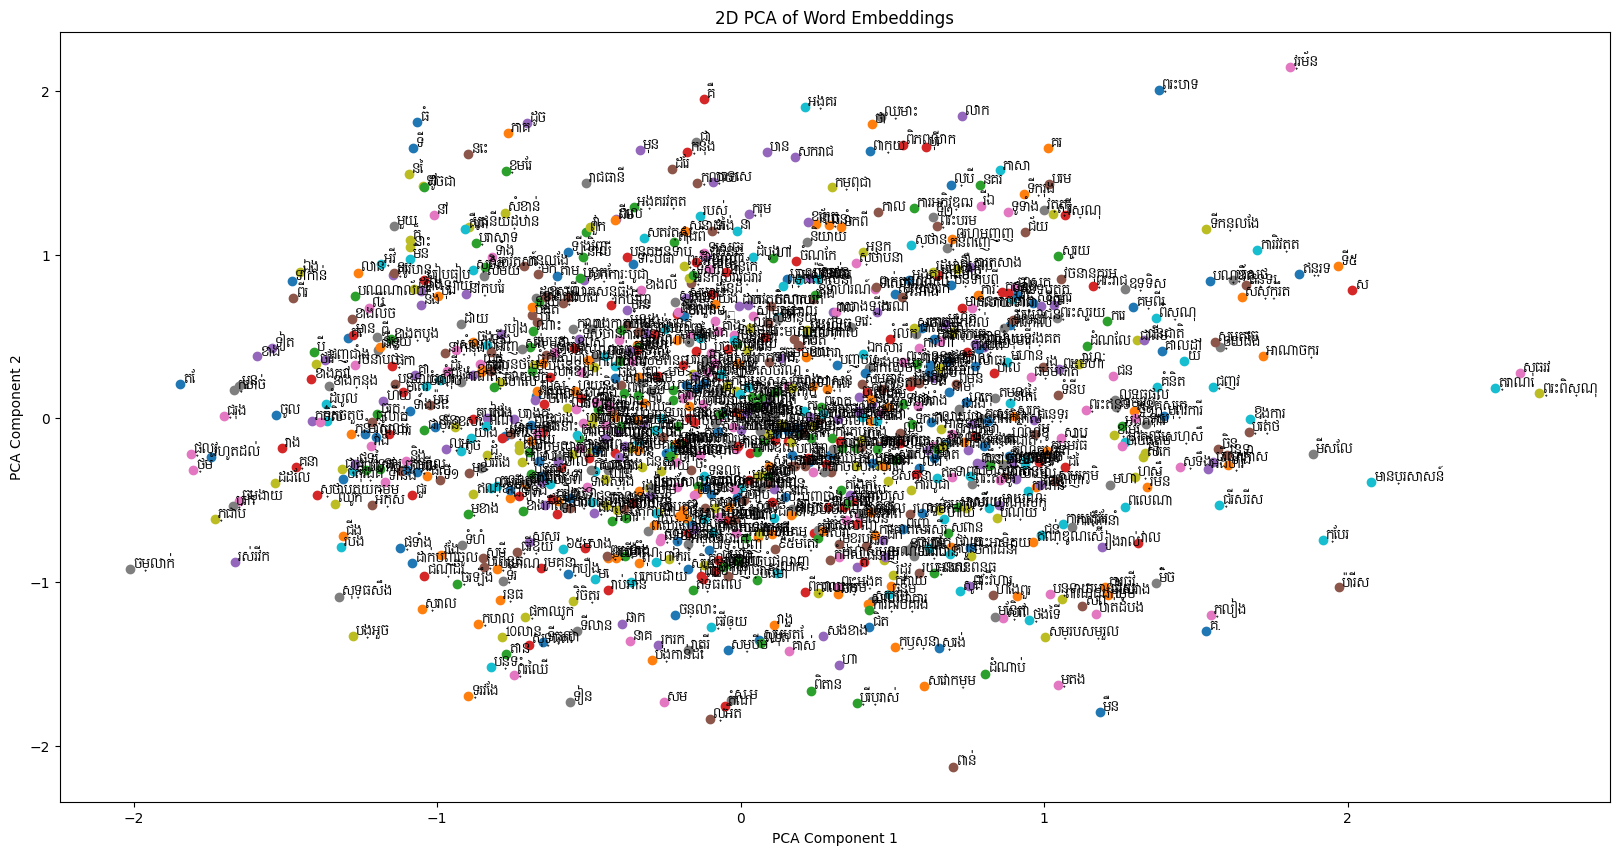

In [97]:
import pathlib

plt.figure(figsize=(20, 10))
for i, embedding in enumerate(reduced_embeddings):
    word = index_to_word[i]
    x, y = embedding
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=9, font=pathlib.Path('KhmerOSContent-Regular.ttf'))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Word Embeddings')
plt.show()

# III. Word Prediction